<a href="https://colab.research.google.com/github/kenanmorani/image_processing_idu/blob/main/3d_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 3D IMage Segmentation using Slicing and 2D-UNET model
* The model is trained on one image of the dataset at http://medicalsegmentation.com/covid19/  (Segmentation dataset nr. 2 (13th April):) using the fisrst image and mask provided.
* The model should be test later on images obtained from other source.



Importing required libraries

In [9]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

In [11]:
# Mounting my google drive
from google.colab import drive

Importing the images and the slices, which are presaved on my google drive and preparing google drive for output paths. 

In [12]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Slicing and Saving

In [ ]:
# Adding the datapaths from my google drive
dataInputPath = '/content/gdrive/MyDrive/Image Processing/data/volumes/'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

In [ ]:
dataOutputPath = '/content/gdrive/MyDrive/Image Processing/data/slices/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')

In [ ]:
# Choosing slicing directions for the 3D images (CT images)
SLICE_X = True
SLICE_Y = True
SLICE_Z = False

In [ ]:
SLICE_DECIMATE_IDENTIFIER = 3

In [ ]:
# Loading image to check max min Hounsfield units
imgPath = os.path.join(imagePathInput, '1.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-1414.765380859375, 212.7372589111328, (630, 630, 45), numpy.memmap)

In [ ]:
# Loading image mask to check max min Hounsfield units
maskPath = os.path.join(maskPathInput, '1.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 2.0, (630, 630, 45), numpy.memmap)

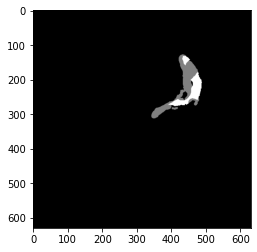

In [ ]:
# Showing image slice
imgSlice = mask[:,:,40]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [ ]:
# Choosing normalization boundaries suitable from the chosen images
HOUNSFIELD_MIN = -1500
HOUNSFIELD_MAX = 210
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

In [ ]:
# Normalizing the images
def normalizeImageIntensityRange (img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.04984480651498538, 1.0, (630, 630, 45), numpy.ndarray)

In [ ]:
# Reading image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=False)
readImageVolume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
# Saving volume slices to file
def saveSlice (img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

In [ ]:
saveSlice(img[20,:,:], 'test', imageSliceOutput)
saveSlice(mask[20,:,:], 'test', maskSliceOutput)

In [ ]:
# Slicing image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt


In [ ]:
# Reading and processing image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/gdrive/MyDrive/Image Processing/data/volumes/img/1.nii (630, 630, 45) 1305 0.04984480651498538 1.0
630 630 45
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/gdrive/MyDrive/Image Processing/data/slices/img/t0-slice629_y.png
/content/gdrive/MyDrive/Image Processing/data/volumes/img/1.nii, 1260 slices created 



In [ ]:
# Reading and processing image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/gdrive/MyDrive/Image Processing/data/volumes/mask/1.nii (630, 630, 45) 1305 0.0 2.0
630 630 45
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/gdrive/MyDrive/Image Processing/data/slices/mask/t0-slice629_y.png
/content/gdrive/MyDrive/Image Processing/data/volumes/mask/1.nii, 1260 slices created 



# Modelling

* The slices done at the previous phase where rearanged in my google drive. The rearangement is as should in the code below under 'NEW PATHS'

In [13]:
# Defining constants
SEED = 909
BATCH_SIZE_TRAIN = 32
# BATCH_SIZE_TEST = 32

In [14]:
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [15]:
# NEW PATHS That images should be at before running the follwoing steps are as shown in green
data_dir = '/content/gdrive/MyDrive/Image Processing/data/slices/'
data_dir_train = os.path.join(data_dir, 'training')
# The images should be stored under: "/content/gdrive/MyDrive/Image Processing/data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images should be stored under: "/content/gdrive/MyDrive/Image Processing/data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

In [16]:
# NUmber of images for training 
NUM_TRAIN = 1261

In [17]:
# Number of epochs for modelling
NUM_OF_EPOCHS = 60

In [18]:
# Data augmentation - applying rescaling of the images
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    img_datagen = ImageDataGenerator(**data_gen_args)
    msk_datagen = ImageDataGenerator(**data_gen_args)
    img_generator = img_datagen.flow_from_directory(img_path, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED, target_size=IMG_SIZE)
    mask_generator = img_datagen.flow_from_directory(msk_path, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED, target_size=IMG_SIZE)
    return zip(img_generator, mask_generator)

In [19]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)    

Found 1261 images belonging to 1 classes.
Found 1261 images belonging to 1 classes.


In [20]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

def show_dataset(datagen, num=1):
    for i in range(0, num):
        image,mask = next(datagen)
        display((image[0], mask[0]))


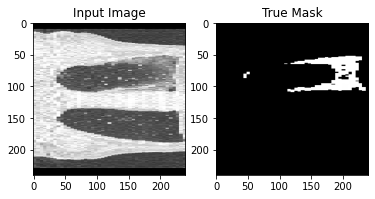

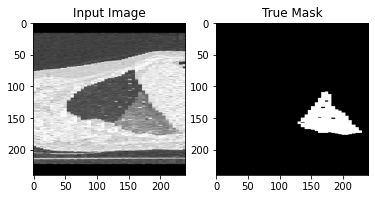

In [21]:
show_dataset(train_generator, 2)

In [22]:
# Building 2D-UNET model
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [23]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
# Choosing optimizers and loss function for the model
model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 32) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [ ]:
# Fitting the 2D-UNET model
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    epochs=NUM_OF_EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
39/39 [==============================] - 1614s 41s/step - loss: 0.3275 - accuracy: 0.9395
Epoch 2/60
39/39 [==============================] - 1604s 41s/step - loss: 0.0666 - accuracy: 0.9814
Epoch 3/60
39/39 [==============================] - 1656s 42s/step - loss: 0.0533 - accuracy: 0.9813
Epoch 4/60
39/39 [==============================] - 1613s 42s/step - loss: 0.0301 - accuracy: 0.9844
Epoch 5/60
39/39 [==============================] - 1629s 42s/step - loss: 0.0181 - accuracy: 0.9899
Epoch 6/60
39/39 [==============================] - 1638s 42s/step - loss: 0.0162 - accuracy: 0.9905
Epoch 7/60
39/39 [==============================] - 1621s 42s/step - loss: 0.0174 - accuracy: 0.9901
Epoch 8/60
39/39 [==============================] - 1625s 42s/step - loss: 0.0139 - accuracy: 0.9906
Epoch 9/60
39/39 [==============================] - 1624s 42s/step - loss: 0.0128 - accuracy: 0.9914
Epoch 10/60
39/39 [==============================] - 1629s 42s/step - loss: 0.0129 - accura